## 3.6 锐化空间滤波器

锐化(sharpen)处理的目的主要是突出灰度的**过渡部分**。

> 图像模糊可以通过在空间域用像素平均法实现，处理方式类似于**积分**。
> 容易想到，图像的锐化可以通过**微分**的方式实现。

本节讨论利用微分算子来锐化图像的各种方法。从基本规律上说，微分算子的响应强度和这一点的突变程度成正比，这样图像微分就能增强边缘和其他突变（比如噪声noise），而削弱灰度变化缓慢的区域。

### 3.6.1 微分与差分

一阶微分(differential)的定义为$\frac{\partial{f}}{\partial{x}}$，离散情况用差分(difference)代替微分，近似表示为$\frac{\partial{f}}{\partial{x}}=f(x+1)-f(x)$.

二阶微分是一阶微分的微分，所以二阶微分用差分代替可以这样表示：
$$\frac{\partial^2{f}}{\partial{x}^2}=(f(x+1)-f(x))-(f(x)-f(x-1))=f(x+1)+f(x-1)-2f(x)$$

考虑一阶微分和二阶微分的性质，对于灰度缓慢过度的梯形区域，一阶微分不为零，二阶微分则非常接近0（对于缓慢过度区域不敏感）。所以二阶微分在增强细节方面要比一阶微分好得多。**这是一个适合锐化图像的理想特性**。

### 3.6.2 使用二阶微分进行图像锐化——拉普拉斯算子

这一节介绍一个最简单的二阶微分算子来进行图像锐化。

> 构造算子的最主要的思想是构造一个微分公式，然后由此公式推导一个滤波器模板。

可以证明（Rosenfeld and Kak[1982]），最简单的各向同性微分算子是拉普拉斯算子。一个二维图像函数$f(x,y)$的拉普拉斯算子(laplace operator)定义为：
$$\nabla^2f=\frac{\partial^2f}{\partial{x}^2}+\frac{\partial^2f}{\partial{y}^2}$$

由上节定义的二阶微分公式，得出两个变量的拉普拉斯离散算子是
$$\nabla^2f(x,y)=f(x+1,y)+f(x-1,y)+f(x,y+1)+f(x,y-1)-4f(x,y)$$

如果用一个模板来表示可以写作：
$$\left(
    \begin{array}{ccc}
        0 & 1 & 0 \\
        1 & -4 & 1\\
        0 & 1 & 0
    \end{array}
   \right)$$
   
可以看出这种最简单的拉普拉斯算子模板只和**上下左右四个方向的像素**有关，另外还有一种包含四个对角的八方向拉普拉斯算子，模板如下：
$$\left(
    \begin{array}{ccc}
        1 & 1 & 1 \\
        1 & -8 & 1\\
        1 & 1 & 1
    \end{array}
   \right)$$
   
> 这里要指出的是，这是拉普拉斯算子在之前定义下推得的模板，此时模板中心为负。还可以通过相反的定义推出一个中心为正，周围为负的模板。

> 符号由微分的定义决定，本质上没有什么不同，但是在某些使用中要注意。（加还是减）

PNG (256, 64) RGB


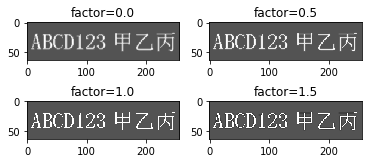

In [55]:
from PIL import Image
from PIL import ImageFilter
from PIL import ImageEnhance

import matplotlib.pyplot as plt
import numpy as np

img = Image.open('images/text.png')
print(img.format, img.size, img.mode)
enhancer = ImageEnhance.Sharpness(img)

plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.6)

for i in range(4):
    factor = i / 2.0
    im = enhancer.enhance(factor)
    plt.subplot(2, 2, i+1)
    plt.imshow(np.array(im))
    plt.title('factor=%.1f' % (factor, ))

### 3.6.3 非锐化掩蔽（Unsharpening Mask）和高提升滤波（High Profile Information Filtering）

本小节介绍的方法在印刷和出版界被使用了很长时间，其主要方法是元图像减去一幅非锐化（平滑过的）版本。

具体由下列步骤组成：

1. 模糊原图像
2. 从原图像中减去模糊图像（产生的差值图像称为模板）
3. 将模板加到原图像上

令$\bar{f}(x,y)$表示模糊的图像，非锐化掩蔽用公式表示如下。首先我们得到模板：
$$g_{mask}(x,y)=f(x,y)-\bar{f}(x,y)$$

然后，在原图像上加上该模板的一个权重部分：
$$g(x,y)=f(x,y)+k*g_{mask}(x,y)$$

上式中的 `k` 称为权重系数。当 k = 1 时，我们得到上面定义的非锐化掩蔽。当 k > 1 时，该处理称为高提升滤波。

> k 代表了非锐化模板的贡献，k大时贡献大，反之，则小。

<img src="http://img.blog.csdn.net/20150131192302681?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvVG9ueVNoZW5nVGFu/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/Center" style="zoom:50%" />

上面的图像展示了非锐化掩蔽的原理。需要注意的是k的取值要小心，一般来说，k越大锐化效果月明显，但是k过大可能会使结果产生**负灰度**。负灰度的出现可能会使边缘出现暗晕轮。

PNG (1067, 267) RGB


TypeError: unsupported operand type(s) for -: 'PngImageFile' and 'Image'

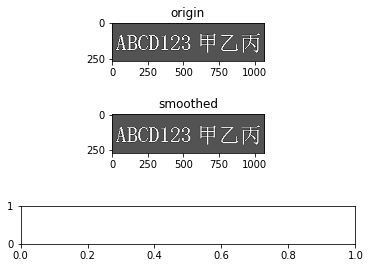

In [155]:
from PIL import Image
from PIL import ImageEnhance
from PIL import ImageFilter
import matplotlib.pyplot as plt
import numpy as np

img = Image.open('images/text.png')

print(img.format, img.size, img.mode)

plt.subplots_adjust(bottom=0.1, top=1.5, hspace=1.4)

plt.subplot(5, 1, 1)
plt.imshow(img, cmap='gray')
plt.title('origin')

plt.subplot(5, 1, 2)
img_smoothed = img.filter(ImageFilter.GaussianBlur(1))
plt.imshow(img_smoothed, cmap='gray')
plt.title('smoothed')

plt.subplot(5, 1, 3)
img_dif = img - img_smoothed
plt.imshow(img_dif, cmap='gray')
plt.title('difference img')

plt.subplot(5, 1, 4)
plt.imshow(img + 1 * img_dif, cmap='gray')
plt.title('Unsharpening Mask')

plt.subplot(5, 1, 5)
k = 3
plt.imshow(img + k * img_dif, cmap='gray')
plt.title('HPIF k = %.1f' % (k, ))


[[ 76 146 227 ..., 246  91 163]
 [146  21  83 ..., 172 137  84]
 [242 252 234 ...,  70  25 166]
 ..., 
 [246  37  26 ..., 204 223  41]
 [104  67  69 ..., 110 108 191]
 [113 200  77 ...,  21 106 245]]


ValueError: Colormap Grays is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10, Vega10_r, Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

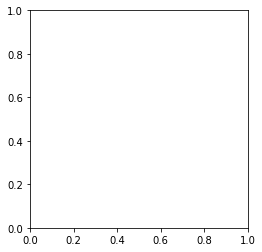

In [162]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img = np.random.randint(256, size=(32, 32))
print(img)
plt.imshow(img, cmap='Grays')                                                                                                             
